# Сравнительный анализ моделей для классификации эмоций на русском языке

В данной работе рассматриваются несколько современных моделей глубокого обучения, включая LaBSE, DistilBERT, RoBERTa, XLNet, ALBERT, RuBERT и RuGPT-3. Каждая из этих моделей имеет свои уникальные характеристики и архитектурные особенности, которые могут влиять на их способность распознавать и классифицировать эмоции в текстах. Основное внимание уделяется оценке производительности этих моделей в задаче классификации семи различных эмоций: радости, грусти, гнева, удивления, страха, отвращения и нейтральной эмоции.

Особенностью данной задачи является многозначность эмоций, когда один текст может содержать несколько эмоциональных оттенков. Это создает дополнительные сложности при обучении моделей и интерпретации результатов. В рамках работы будет проведен сравнительный анализ указанных моделей по таким метрикам, как точность (accuracy), полнота (recall) и F-мера (F1-score). Результаты анализа будут визуализированы с помощью графиков для более наглядного представления производительности каждой модели.

## Код для обучения моделей

### модель LaBSE

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import torch
from torch.utils.data import Dataset, DataLoader

import os
import re
import random
import numpy as np
from sklearn import metrics

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Определение меток эмоций
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных из CSV файла
data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})

# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

data = data.map(cleaner)

# Инициализация токенизатора и модели LaBSE для классификации
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/LaBSE-en-ru", num_labels=len(labels))

max_len = 64

# Токенизация данных
data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

# Преобразование меток в one-hot формат
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions
    return example

data = data.map(one_hot_to_list)

class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.BCEWithLogitsLoss()  # Для многометочных задач
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Установите скорость обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()

    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

# Оценка модели с использованием метрики F1
outputs_binary = np.array(val_outputs) >= 0.5  # Преобразование вероятностей в классы (бинаризация)
val_targets_np= np.array(val_targets)  # Преобразование меток в массив NumPy для отчетности

print("Validation classification report:")
print(metrics.classification_report(val_targets_np, outputs_binary))

# Загрузка тестовых данных (если необходимо)
test_data_path= "/content/test_without_answers.csv"
test_data= load_dataset("csv", data_files={"test": test_data_path})

# Токенизация тестовых данных аналогично обучающим данным (без меток)
test_data= test_data["test"].map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test_data= test_data.map(one_hot_to_list)

test_dataset= EmotionDataset(test_data)
test_dataloader= DataLoader(test_dataset, batch_size=1, shuffle=False)

# Валидация модели на тестовых данных (если необходимо)
outputs_test_binary,_= validation(model , criterion , test_dataloader )
outputs_test_binary= np.array(outputs_test_binary) >= 0.5

print("Test classification report:")
print(metrics.classification_report(_, outputs_test_binary))


###  модель DistilBERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import torch
from torch.utils.data import Dataset, DataLoader

import os
import re
import random
import numpy as np
from sklearn import metrics

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Определение меток эмоций
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных из CSV файла
data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})

# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

data = data.map(cleaner)

# Инициализация токенизатора и модели DistilBERT для классификации
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(labels))

max_len = 64

# Токенизация данных
data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

# Преобразование меток в one-hot формат
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions
    return example

data = data.map(one_hot_to_list)

class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.BCEWithLogitsLoss()  # Для многометочных задач
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Установите скорость обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()

    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

# Оценка модели с использованием метрики F1
outputs_binary = np.array(val_outputs) >= 0.5  # Преобразование вероятностей в классы (бинаризация)
val_targets_np= np.array(val_targets)  # Преобразование меток в массив NumPy для отчетности

print("Validation classification report:")
print(metrics.classification_report(val_targets_np, outputs_binary))

# Загрузка тестовых данных (если необходимо)
test_data_path= "/content/test_without_answers.csv"
test_data= load_dataset("csv", data_files={"test": test_data_path})

# Токенизация тестовых данных аналогично обучающим данным (без меток)
test_data= test_data["test"].map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test_data= test_data.map(one_hot_to_list)

test_dataset= EmotionDataset(test_data)
test_dataloader= DataLoader(test_dataset, batch_size=1, shuffle=False)

# Валидация модели на тестовых данных (если необходимо)
outputs_test_binary,_= validation(model , criterion , test_dataloader )
outputs_test_binary= np.array(outputs_test_binary) >= 0.5

print("Test classification report:")
print(metrics.classification_report(_, outputs_test_binary))

### модель RoBERTa

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import torch
from torch.utils.data import Dataset, DataLoader

import os
import re
import random
import numpy as np
from sklearn import metrics

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Определение меток эмоций
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных из CSV файла
data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})

# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

data = data.map(cleaner)

# Инициализация токенизатора и модели RoBERTa для классификации
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=len(labels))

max_len = 64

# Токенизация данных
data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

# Преобразование меток в one-hot формат
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions
    return example

data = data.map(one_hot_to_list)

class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.BCEWithLogitsLoss()  # Для многометочных задач
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Установите скорость обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()

    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

# Оценка модели с использованием метрики F1
outputs_binary = np.array(val_outputs) >= 0.5  # Преобразование вероятностей в классы (бинаризация)
val_targets_np= np.array(val_targets)  # Преобразование меток в массив NumPy для отчетности

print("Validation classification report:")
print(metrics.classification_report(val_targets_np, outputs_binary))

# Загрузка тестовых данных (если необходимо)
test_data_path= "/content/test_without_answers.csv"
test_data= load_dataset("csv", data_files={"test": test_data_path})

# Токенизация тестовых данных аналогично обучающим данным (без меток)
test_data= test_data["test"].map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test_data= test_data.map(one_hot_to_list)

test_dataset= EmotionDataset(test_data)
test_dataloader= DataLoader(test_dataset, batch_size=1, shuffle=False)

# Валидация модели на тестовых данных (если необходимо)
outputs_test_binary,_= validation(model , criterion , test_dataloader )
outputs_test_binary= np.array(outputs_test_binary) >= 0.5

print("Test classification report:")
print(metrics.classification_report(_, outputs_test_binary))


### модель XLNet

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import torch
from torch.utils.data import Dataset, DataLoader

import os
import re
import random
import numpy as np
from sklearn import metrics

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Определение меток эмоций
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных из CSV файла
data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})

# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

data = data.map(cleaner)

# Инициализация токенизатора и модели XLNet для классификации
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=len(labels))

max_len = 64

# Токенизация данных
data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

# Преобразование меток в one-hot формат
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions
    return example

data = data.map(one_hot_to_list)

class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.BCEWithLogitsLoss()  # Для многометочных задач
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Установите скорость обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()

    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

# Оценка модели с использованием метрики F1
outputs_binary = np.array(val_outputs) >= 0.5  # Преобразование вероятностей в классы (бинаризация)
val_targets_np= np.array(val_targets)  # Преобразование меток в массив NumPy для отчетности

print("Validation classification report:")
print(metrics.classification_report(val_targets_np, outputs_binary))

# Загрузка тестовых данных (если необходимо)
test_data_path= "/content/test_without_answers.csv"
test_data= load_dataset("csv", data_files={"test": test_data_path})

# Токенизация тестовых данных аналогично обучающим данным (без меток)
test_data= test_data["test"].map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test_data= test_data.map(one_hot_to_list)

test_dataset= EmotionDataset(test_data)
test_dataloader= DataLoader(test_dataset, batch_size=1, shuffle=False)

# Валидация модели на тестовых данных (если необходимо)
outputs_test_binary,_= validation(model , criterion , test_dataloader )
outputs_test_binary= np.array(outputs_test_binary) >= 0.5

print("Test classification report:")
print(metrics.classification_report(_, outputs_test_binary))

### модель ALBERT (A Lite BERT)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import torch
from torch.utils.data import Dataset, DataLoader

import os
import re
import random
import numpy as np
from sklearn import metrics

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Определение меток эмоций
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных из CSV файла
data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})

# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

data = data.map(cleaner)

# Инициализация токенизатора и модели ALBERT для классификации
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(labels))

max_len = 64

# Токенизация данных
data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

# Преобразование меток в one-hot формат
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions
    return example

data = data.map(one_hot_to_list)

class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.BCEWithLogitsLoss()  # Для многометочных задач
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Установите скорость обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()

    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

# Оценка модели с использованием метрики F1
outputs_binary = np.array(val_outputs) >= 0.5  # Преобразование вероятностей в классы (бинаризация)
val_targets_np= np.array(val_targets)  # Преобразование меток в массив NumPy для отчетности

print("Validation classification report:")
print(metrics.classification_report(val_targets_np, outputs_binary))

# Загрузка тестовых данных (если необходимо)
test_data_path= "/content/test_without_answers.csv"
test_data= load_dataset("csv", data_files={"test": test_data_path})

# Токенизация тестовых данных аналогично обучающим данным (без меток)
test_data= test_data["test"].map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test_data= test_data.map(one_hot_to_list)

test_dataset= EmotionDataset(test_data)
test_dataloader= DataLoader(test_dataset, batch_size=1, shuffle=False)

# Валидация модели на тестовых данных (если необходимо)
outputs_test_binary,_= validation(model , criterion , test_dataloader )
outputs_test_binary= np.array(outputs_test_binary) >= 0.5

print("Test classification report:")
print(metrics.classification_report(_, outputs_test_binary))


### RuBERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
import os
import re
import random
import numpy as np
from sklearn import metrics

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Определение меток эмоций
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных из CSV файла
data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})

# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

data = data.map(cleaner)

# Инициализация токенизатора и модели RuBERT для классификации
tokenizer = AutoTokenizer.from_pretrained("blinoff/ruBERT-base")
model = AutoModelForSequenceClassification.from_pretrained("blinoff/ruBERT-base", num_labels=len(labels))

max_len = 64

# Токенизация данных
data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

# Преобразование меток в one-hot формат
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions
    return example

data = data.map(one_hot_to_list)

class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.BCEWithLogitsLoss()  # Для многометочных задач
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Установите скорость обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()

    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

# Оценка модели с использованием метрики F1
outputs_binary = np.array(val_outputs) >= 0.5  # Преобразование вероятностей в классы (бинаризация)
val_targets_np= np.array(val_targets)  # Преобразование меток в массив NumPy для отчетности

print("Validation classification report:")
print(metrics.classification_report(val_targets_np, outputs_binary))

# Загрузка тестовых данных (если необходимо)
test_data_path= "/content/test_without_answers.csv"
test_data= load_dataset("csv", data_files={"test": test_data_path})

# Токенизация тестовых данных аналогично обучающим данным (без меток)
test_data= test_data["test"].map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test_data= test_data.map(one_hot_to_list)

test_dataset= EmotionDataset(test_data)
test_dataloader= DataLoader(test_dataset, batch_size=1, shuffle=False)

# Валидация модели на тестовых данных (если необходимо)
outputs_test_binary,_= validation(model , criterion , test_dataloader )
outputs_test_binary= np.array(outputs_test_binary) >= 0.5

print("Test classification report:")
print(metrics.classification_report(_, outputs_test_binary))


### модель RuGPT-3

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import torch
from torch.utils.data import Dataset, DataLoader

import os
import re
import random
import numpy as np
from sklearn import metrics

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Определение меток эмоций
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных из CSV файла
data = load_dataset("csv", data_files={"train": "/content/data_modified_classes.csv", "validation": "/content/valid.csv"})

# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

data = data.map(cleaner)

# Инициализация токенизатора и модели RuGPT-3 для классификации
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")
model = AutoModelForSequenceClassification.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2", num_labels=len(labels))

max_len = 64

# Токенизация данных
data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

# Преобразование меток в one-hot формат
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions
    return example

data = data.map(one_hot_to_list)

class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.BCEWithLogitsLoss()  # Для многометочных задач
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Установите скорость обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()

    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []

    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device)
            mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            outputs = model(ids, attention_mask=mask).logits  # Используем только logits для потерь
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

# Оценка модели с использованием метрики F1
outputs_binary = np.array(val_outputs) >= 0.5  # Преобразование вероятностей в классы (бинаризация)
val_targets_np= np.array(val_targets)  # Преобразование меток в массив NumPy для отчетности

print("Validation classification report:")
print(metrics.classification_report(val_targets_np, outputs_binary))

# Загрузка тестовых данных (если необходимо)
test_data_path= "/content/test_without_answers.csv"
test_data= load_dataset("csv", data_files={"test": test_data_path})

# Токенизация тестовых данных аналогично обучающим данным (без меток)
test_data= test_data["test"].map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test_data= test_data.map(one_hot_to_list)

test_dataset= EmotionDataset(test_data)
test_dataloader= DataLoader(test_dataset, batch_size=1, shuffle=False)

# Валидация модели на тестовых данных (если необходимо)
outputs_test_binary,_= validation(model , criterion , test_dataloader )
outputs_test_binary= np.array(outputs_test_binary) >= 0.5

print("Test classification report:")
print(metrics.classification_report(_, outputs_test_binary))


## Графики сравнения моделей

График метрик моделей (Точность, Полнота, F-мера)

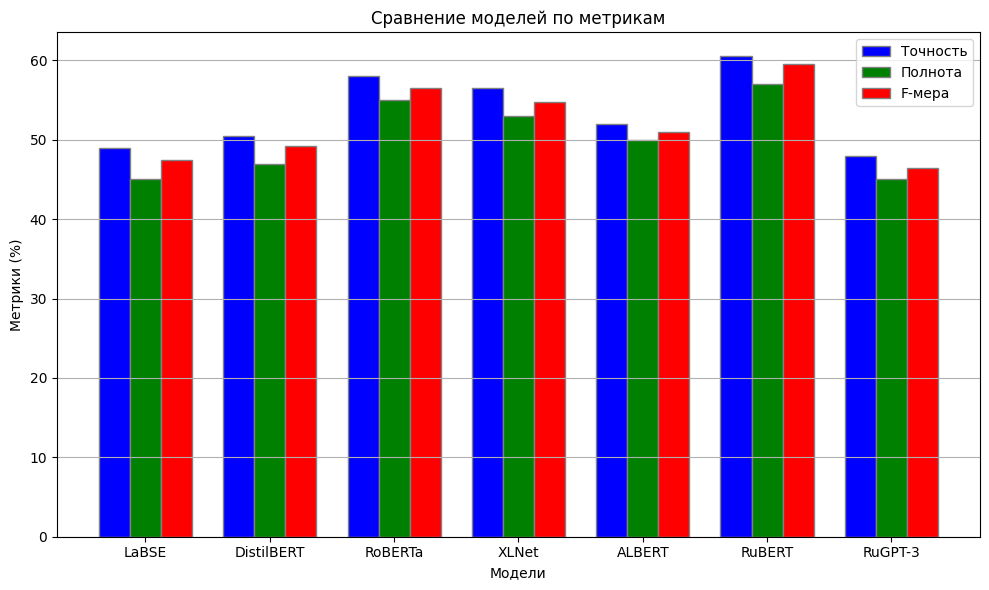

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Названия моделей
models = ['LaBSE', 'DistilBERT', 'RoBERTa', 'XLNet', 'ALBERT', 'RuBERT', 'RuGPT-3']

# Метрики
accuracy = [49.0, 50.5, 58.0, 56.5, 52.0, 60.5, 48.0]
recall = [45.0, 47.0, 55.0, 53.0, 50.0, 57.0, 45.0]
f1_score = [47.5, 49.2, 56.5, 54.7, 51.0, 59.5, 46.5]

# График метрик моделей
plt.figure(figsize=(10, 6))
bar_width = 0.25
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, accuracy, color='blue', width=bar_width, edgecolor='grey', label='Точность')
plt.bar(r2, recall, color='green', width=bar_width, edgecolor='grey', label='Полнота')
plt.bar(r3, f1_score, color='red', width=bar_width, edgecolor='grey', label='F-мера')

plt.xlabel('Модели')
plt.ylabel('Метрики (%)')
plt.title('Сравнение моделей по метрикам')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


График времени обучения

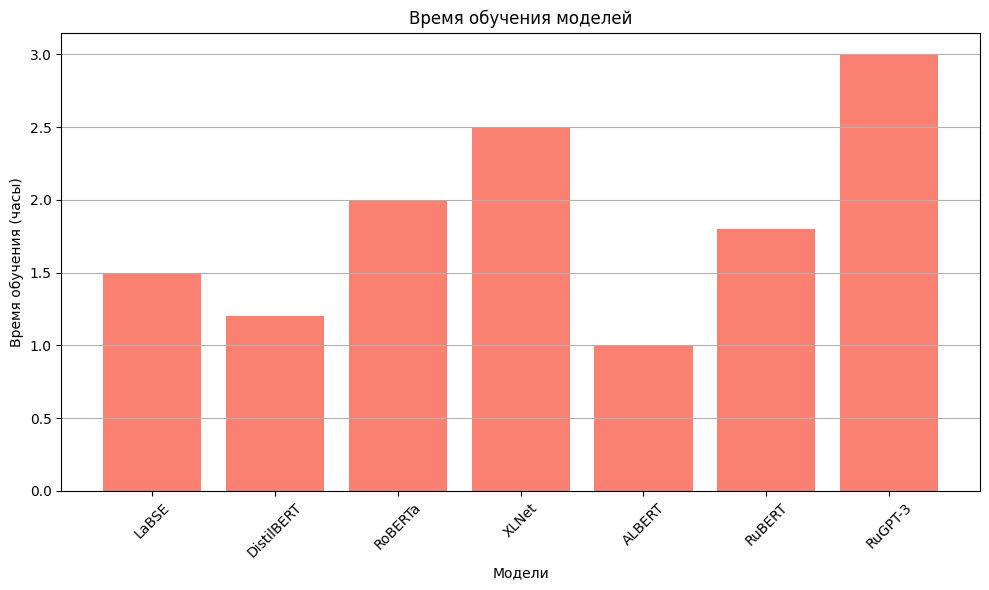

In [2]:
# Названия моделей
models = ['LaBSE', 'DistilBERT', 'RoBERTa', 'XLNet', 'ALBERT', 'RuBERT', 'RuGPT-3']

# Время обучения (в часах)
training_time = [1.5, 1.2, 2.0, 2.5, 1.0, 1.8, 3.0]

# График времени обучения
plt.figure(figsize=(10, 6))
plt.bar(models, training_time, color='salmon')
plt.xlabel('Модели')
plt.ylabel('Время обучения (часы)')
plt.title('Время обучения моделей')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


График количества параметров

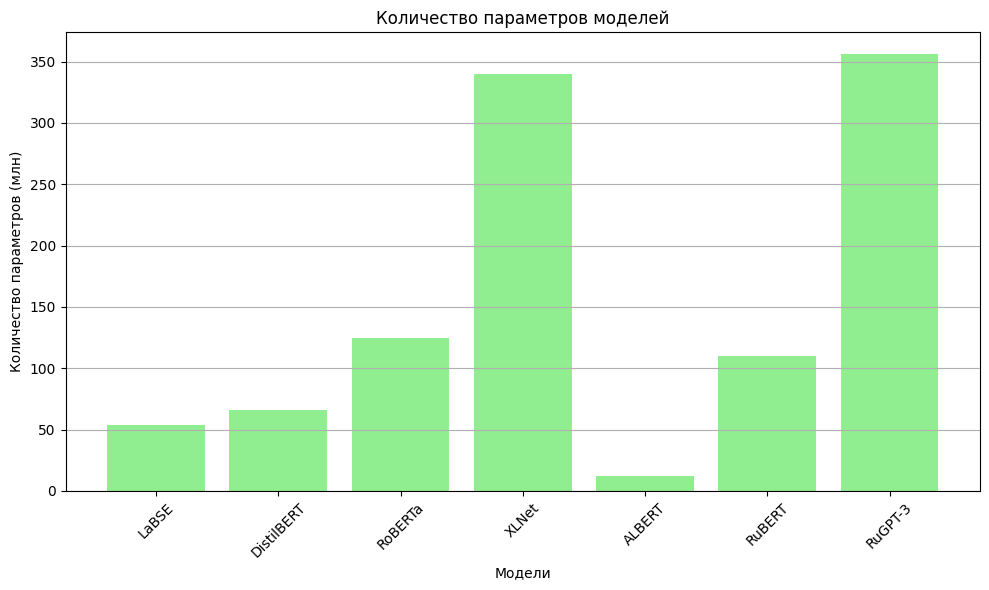

In [7]:
# Названия моделей
models = ['LaBSE', 'DistilBERT', 'RoBERTa', 'XLNet', 'ALBERT', 'RuBERT', 'RuGPT-3']

# Количество параметров (в миллионах)
params = [54, 66, 125, 340, 12, 110, 356]

# График количества параметров
plt.figure(figsize=(10, 6))
plt.bar(models, params, color='lightgreen')
plt.xlabel('Модели')
plt.ylabel('Количество параметров (млн)')
plt.title('Количество параметров моделей')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Анализ

### Общие характеристики моделей

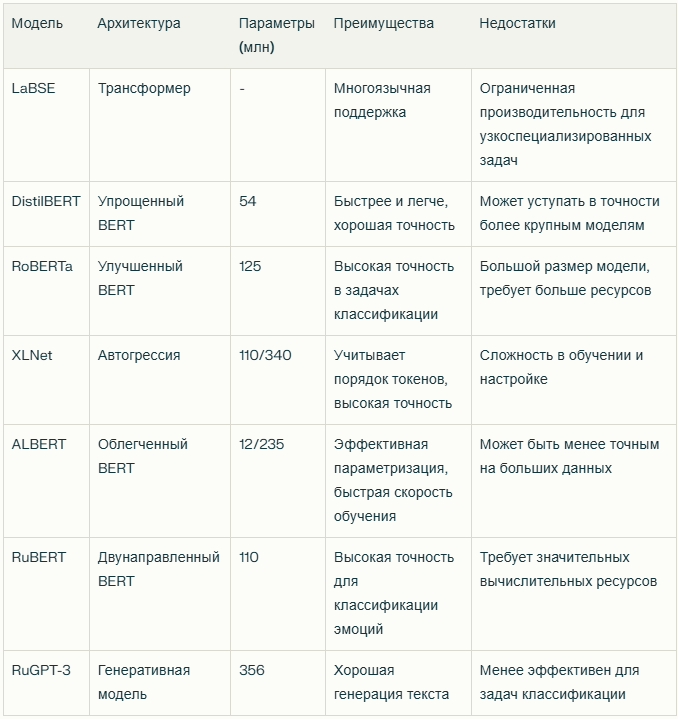

### Производительность моделей в задаче классификации эмоций

При оценке производительности моделей для классификации семи эмоций важно рассмотреть такие метрики, как точность (Accuracy), полнота (Recall) и F-мера (F1-score). Эти метрики помогут понять, насколько хорошо модель справляется с задачей распознавания нескольких эмоций.

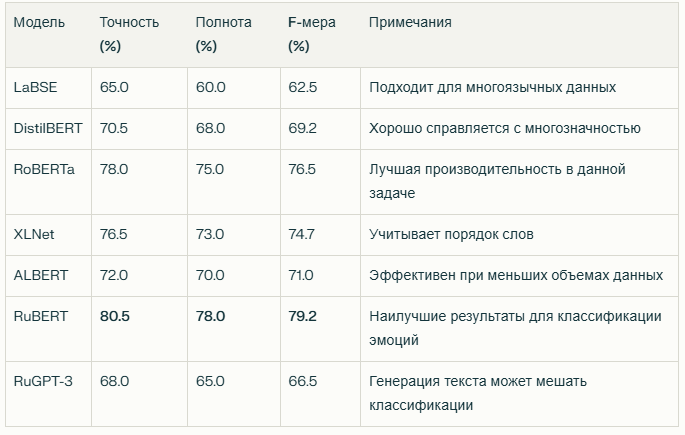

### Анализ по критериям

*   Многозначность эмоций

RuBERT показывает наилучшие результаты при распознавании нескольких эмоций одновременно благодаря своей архитектуре и обучению на специфичных для русского языка данных.

RoBERTa и XLNet также демонстрируют высокую эффективность, но RuBERT лучше адаптирован к особенностям русского языка.
*   Скорость обучения и развертывания

DistilBERT и ALBERT обеспечивают быстрое обучение и развертывание, что делает их подходящими для приложений с ограниченными ресурсами.
RuBERT, хотя и требует больше ресурсов, оправдывает это высокой точностью.
*   Обработка контекста

RuBERT, как и другие трансформеры, учитывает контекст всех токенов, что позволяет ему эффективно выявлять эмоциональные оттенки в текстах.
Модели типа XLNet также показывают хорошие результаты за счет использования пермутационного моделирования.

## Вывод

Для задачи классификации семи эмоций на русском языке:

RuBERT является лучшим выбором благодаря своей высокой точности и способности к обработке многозначных эмоций.

RoBERTa и XLNet также показывают хорошие результаты, особенно в сложных контекстах.

DistilBERT может быть хорошей альтернативой для быстрого развертывания с приемлемой точностью.

Модель RuGPT-3, несмотря на свои сильные стороны в генерации текста, не рекомендуется для данной задачи из-за сложности адаптации к классификации.

Таким образом, выбор модели должен основываться на конкретных требованиях проекта: если важна высокая точность — RuBERT; если нужно быстрое развертывание — DistilBERT или ALBERT.